# LNP Internalization

- Imaging DATE: 2024-09-17

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioio import BioImage
from scipy import ndimage as ndi
from skimage import io, filters, exposure, segmentation, morphology, measure, feature
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 18,

    'lines.linewidth': 2,

    'axes.linewidth': 2,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',

    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,

    'figure.dpi': 80,
    'savefig.dpi': 80,

    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14,

    'animation.html': 'html5',
})

In [3]:
DATE = '2024-09-17'
IMG_DIR = f'img_data/{DATE}'
IMG_FILENAMES = np.array([
    'exp_1_LNP_np.czi',
    'exp_2_cellonly_np.czi',
    'exp_3_LNP_VTN.czi',
    'exp_4_cellonly_VTN.czi',
    'exp_5_LNP_A2M.czi',
    'exp_6_cellonly_A2M.czi',
    'exp_7_LNP_CR.czi',
    'exp_8_cellonly_CR.czi',
    'exp_9_cellonly_np.czi',
    'exp_10_LNP_np.czi',
    'exp_11_LNP_VTN.czi',
    'exp_12_LNP_A2M.czi',
    'exp_13_LNP_CR.czi',
    'exp_14_cellonly_np.czi',
    'exp_15_LNP_np.czi',
    'exp_16_LNP_VTN.czi',
    'exp_17_LNP_A2M.czi',
    'exp_18_LNP_CR.czi',
])
LNP_CHANNEL_IDX = 1
MEMBRANE_CHANNEL_IDX = 3
NUCLEUS_CHANNEL_IDX = 5

## Tuning thresholding methods

In [4]:
def get_scene_img(img, scene_idx):
    img.set_scene(scene_idx)
    lazy_t0 = img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
    t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
    return t0

In [5]:
def get_membrane_mask(img):
    # segmentation by histogram-based thresholding
    threshold = filters.threshold_li(img)
    mask = (img > threshold)
    
    # post-segmentation image processing
    mask = morphology.remove_small_objects(mask, 3000)
    mask = morphology.remove_small_holes(mask, 300)
    mask = ndi.binary_fill_holes(mask)
    return mask

def get_inner_membrane_mask(mask, n_erosion=10):
    inner_mask = mask.copy()
    for k in range(n_erosion):
        inner_mask = morphology.erosion(inner_mask)
    return inner_mask

def get_inner_outer_membrane_masks(mask, n_erosion=10):
    inner_mask = get_inner_membrane_mask(mask, n_erosion=n_erosion)
    outer_mask = np.bitwise_xor(inner_mask, membrane_mask)
    return inner_mask, outer_mask

def get_nucleus_mask(img):
    # adjust the histogram for image pre-thresholding
    processed_img = exposure.equalize_hist(img)
    
    # segmentation of img by local thresholding on processed_img
    threshold = filters.threshold_local(
        processed_img,
        block_size=35,  # 35
        offset=-3,  # -15 is good for exp 3, -3 is good for exp 1
    )
    mask = (img > threshold)
    
    # post-segmentation image processing
    mask = ndi.binary_fill_holes(mask)
    mask = morphology.remove_small_holes(mask)
    mask = morphology.remove_small_objects(mask, 500)
    for k in range(2):
        mask = morphology.erosion(mask)
    mask = morphology.remove_small_objects(mask, 2000)
    return mask

In [6]:
def remove_uncolocalized_objects(mask1, mask2, verbose=False):
    """
    mask1 contains objects of interest to be removed according to colocalization with mask 2
    Only removes objects that are completely not colocalized. Not based on percentage of colocalization.
    """
    mask1 = mask1.copy()  # avoid data leakage across scope
    mask2 = mask2.copy()  # avoid data leakage across scope
    labeled_mask1 = measure.label(mask1)
    for i in range(1, labeled_mask1.max() + 1):  # zero is background, shift to start from 1
        individual_labeled_mask1 = (labeled_mask1 == i)  # mask of one membrane
        colocalized_mask1 = np.logical_and(individual_labeled_mask1, mask2)  # all zeros if not colocalized
        colocalization_ratio = colocalized_mask1.sum() / individual_labeled_mask1.sum()  # how much is colocalized?
        is_colocalized = bool(colocalization_ratio)
        if not is_colocalized:
            mask1[labeled_mask1 == i] = 0  # remove uncolocalized membranes
            if verbose:
                print(f'Removed {i}th object')
    return mask1

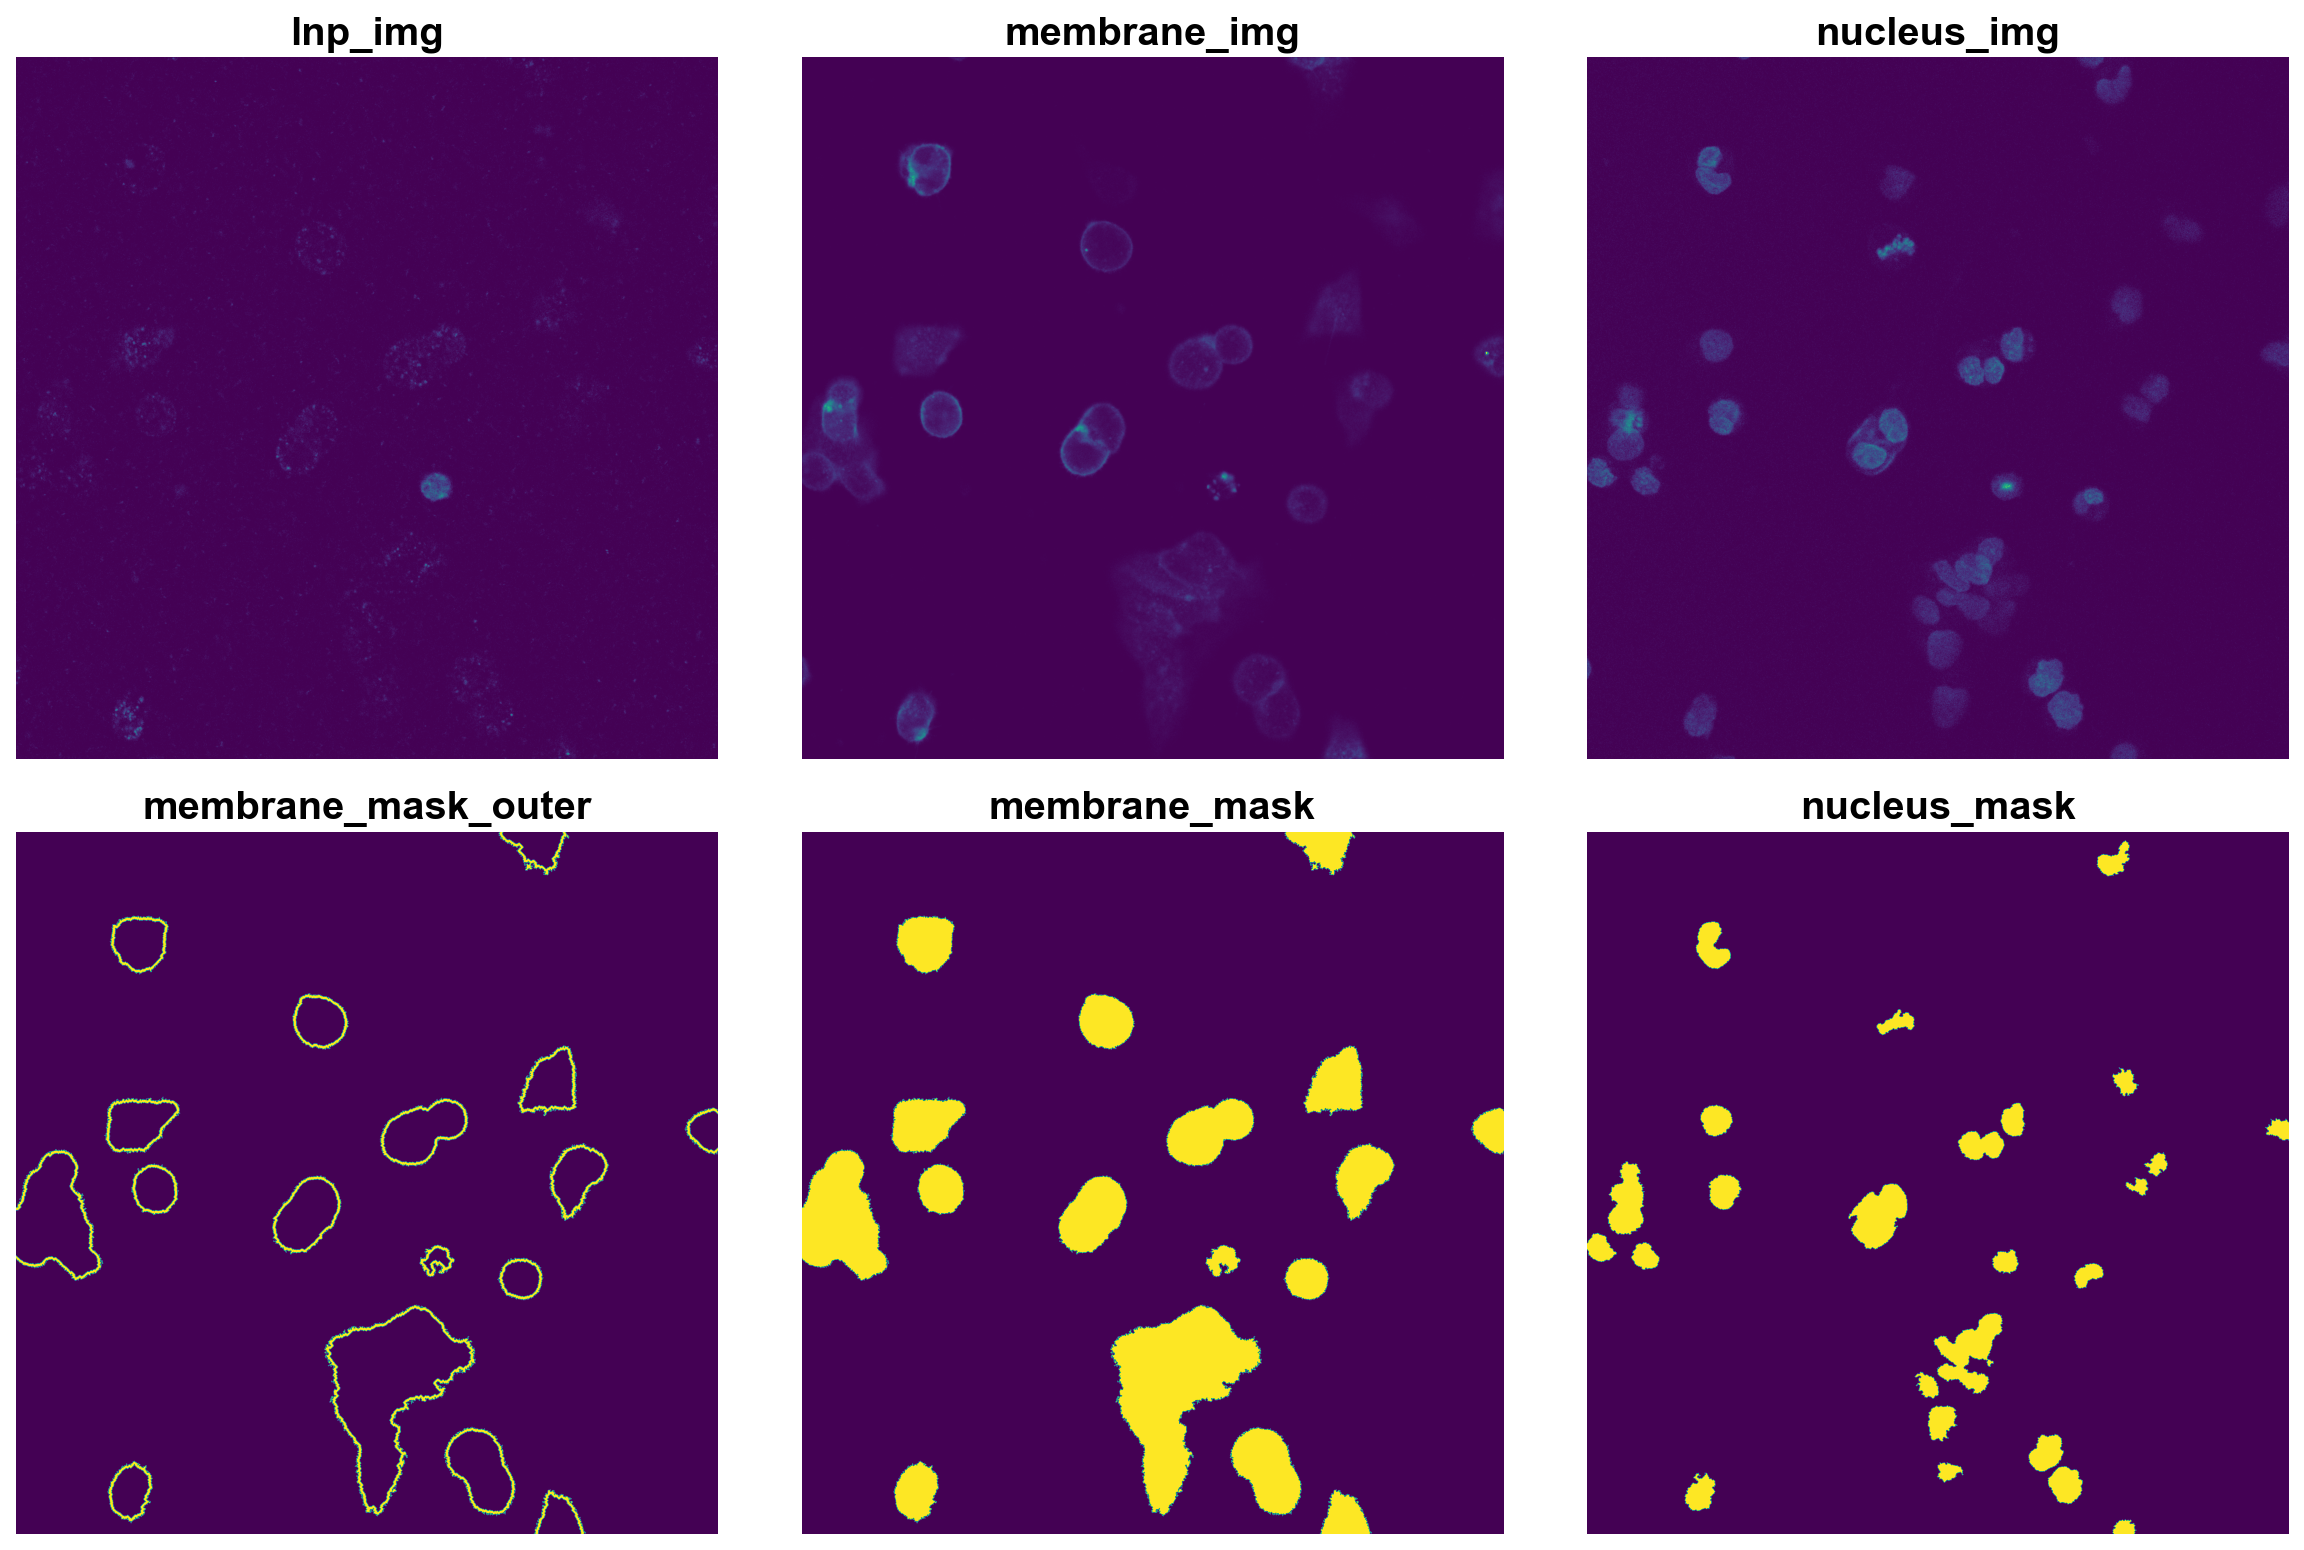

In [7]:
filename_idx = 0
scene_idx = 0
n_erosion = 10

# read the czi image stack
img_filename = os.path.join(IMG_DIR, IMG_FILENAMES[filename_idx])
raw_img = BioImage(img_filename)
img = get_scene_img(raw_img, scene_idx)
lnp_img = img[LNP_CHANNEL_IDX, :, :]
membrane_img = img[MEMBRANE_CHANNEL_IDX, :, :]
nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]

membrane_mask = get_membrane_mask(membrane_img)
nucleus_mask = get_nucleus_mask(nucleus_img)
membrane_mask = remove_uncolocalized_objects(membrane_mask, nucleus_mask)
nucleus_mask = remove_uncolocalized_objects(nucleus_mask, membrane_mask)
membrane_mask_inner, membrane_mask_outer = get_inner_outer_membrane_masks(
    membrane_mask, 
    n_erosion=n_erosion,
)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(lnp_img)
axs[0, 1].imshow(membrane_img)
axs[0, 2].imshow(nucleus_img)
axs[1, 0].imshow(membrane_mask_outer)
axs[1, 1].imshow(membrane_mask)
axs[1, 2].imshow(nucleus_mask)

axs[0, 0].set_title('lnp_img')
axs[0, 1].set_title('membrane_img')
axs[0, 2].set_title('nucleus_img')
axs[1, 0].set_title('membrane_mask_outer')
axs[1, 1].set_title('membrane_mask')
axs[1, 2].set_title('nucleus_mask')

for i in range(2):
    for j in range(3):
        axs[i, j].axis('off')
plt.tight_layout()

## Quantifying internalization

In [8]:
def get_object_count(mask):
    return np.unique(measure.label(mask))[-1]

In [9]:
def to_numeric_df(df):
    df = df.copy()  # avoid data leakage
    for i, column in enumerate(df.columns):
        try:
            df.iloc[:, i] = pd.to_numeric(df.iloc[:, i])
        except:
            pass
    return df

In [10]:
def get_img_in_mask(img, mask):
    masked_img = img.copy()
    masked_img[~mask] = 0
    return masked_img

In [11]:
def save_img(img, img_label):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{img_label}\n{filename}, S{scene_idx}', fontsize=12)
    fig_filepath = os.path.join(f'processed_img/{DATE}', f'{filename}_s{scene_idx}_{img_label}.png')
    fig.savefig(fig_filepath)
    plt.close()

In [12]:
metadata_name_list = [
    'Filename',
    'Scene ID',
]
property_name_list = [
    'Total LNP intensity in entire img',
    'Total membrane intensity in entire img',
    'Total nucleus intensity in entire img',
    
    'LNP intensity in membrane mask',
    'LNP intensity in nucleus mask',
    'LNP intensity in inner membrane mask',
    'LNP intensity in outer membrane mask',
    
    'LNP intensity in membrane mask per membrane count',
    'LNP intensity in nucleus mask per nucleus count',
    
    'Frac LNP intensity in membrane mask over total LNP intensity',
    'Frac LNP intensity in nucleus mask over total LNP intensity',
    
    'Frac LNP intensity in membrane inner mask over LNP intensity in membrane mask',
    'Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask',
    
    'Membrane count',
    'Nucleus count',
]
all_property_name_list = metadata_name_list + property_name_list

In [ ]:
SAVE_IMG = True
sample_property_list = []

for j, filename in enumerate(IMG_FILENAMES):
    filepath = os.path.join(IMG_DIR, filename)
    raw_img = BioImage(filepath)
    for scene_idx in range(len(raw_img.scenes)):
        # get image data
        img = get_scene_img(raw_img, scene_idx)
        lnp_img = img[LNP_CHANNEL_IDX, :, :]
        membrane_img = img[MEMBRANE_CHANNEL_IDX, :, :]
        nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]
    
        ## segmentation of membrane and nucleus
        membrane_mask = get_membrane_mask(membrane_img)
        nucleus_mask = get_nucleus_mask(nucleus_img)
        membrane_mask = remove_uncolocalized_objects(membrane_mask, nucleus_mask)
        nucleus_mask = remove_uncolocalized_objects(nucleus_mask, membrane_mask)
        membrane_mask_inner, membrane_mask_outer = get_inner_outer_membrane_masks(
            membrane_mask, 
            n_erosion=n_erosion,
        )

        ## masked LNP image
        lnp_in_membrane_img = get_img_in_mask(lnp_img, membrane_mask)
        lnp_in_nucleus_img = get_img_in_mask(lnp_img, nucleus_mask)
        lnp_in_inner_membrane_img = get_img_in_mask(lnp_img, membrane_mask_inner)
        lnp_in_outer_membrane_img = get_img_in_mask(lnp_img, membrane_mask_outer)

        # calculate intensities
        lnp_intensity = lnp_img.sum()
        membrane_intensity = membrane_img.sum()
        nucleus_intensity = nucleus_img.sum()
        lnp_in_membrane_intensity = lnp_in_membrane_img.sum()
        lnp_in_nucleus_intensity = lnp_in_nucleus_img.sum()
        lnp_in_inner_membrane_intensity = lnp_in_inner_membrane_img.sum()
        lnp_in_outer_membrane_intensity = lnp_in_outer_membrane_img.sum()

        # calculate object counts
        membrane_count = get_object_count(membrane_mask)
        nucleus_count = get_object_count(nucleus_mask)

        sample_property_list.append([
            # meta data
            filename, 
            scene_idx,

            # total intensity in each channel
            lnp_intensity,
            membrane_intensity,
            nucleus_intensity,

            # lnp intensity in mask
            lnp_in_membrane_intensity,
            lnp_in_nucleus_intensity,
            lnp_in_inner_membrane_intensity,
            lnp_in_outer_membrane_intensity,

            # lnp intensity in mask per boundary number
            lnp_in_membrane_intensity / membrane_count,
            lnp_in_nucleus_intensity / nucleus_count,

            # fraction of lnp intensity in mask vs total lnp intensity
            lnp_in_membrane_intensity / lnp_intensity,
            lnp_in_nucleus_intensity / lnp_intensity,

            # fraction of lnp intensity in inner and outer membrane mask vs lnp intensity in membrane mask
            lnp_in_inner_membrane_intensity / lnp_in_membrane_intensity,
            lnp_in_outer_membrane_intensity / lnp_in_membrane_intensity,
            
            # object count
            membrane_count,
            nucleus_count,
        ])

        if SAVE_IMG:
            save_img(lnp_img, 'lnp_img')
            save_img(nucleus_img, 'nucleus_img')
            save_img(membrane_img, 'membrane_img')
            
            save_img(membrane_mask, 'membrane_mask')
            save_img(nucleus_mask, 'nucleus_mask')
            save_img(membrane_mask_inner, 'membrane_mask_inner')
            save_img(membrane_mask_outer, 'membrane_mask_outer')
            
            save_img(lnp_in_membrane_img, 'lnp_in_membrane_img')
            save_img(lnp_in_nucleus_img, 'lnp_in_nucleus_img')
            save_img(lnp_in_inner_membrane_img, 'lnp_in_inner_membrane_img')
            save_img(lnp_in_outer_membrane_img, 'lnp_in_outer_membrane_img')

In [ ]:
properties_df = pd.DataFrame(np.array(sample_property_list))
properties_df.columns = all_property_name_list
properties_df = to_numeric_df(properties_df)
properties_df

In [ ]:
properties_df_filename = os.path.join(f'processed_data/{DATE}', f"properties_df.csv")
properties_df.to_csv(df_filename)

### Filter for membrane and nucleus count

In [ ]:
# filtered_df = properties_df[(properties_df['Nucleus count'] >= 5)]
filtered_df = properties_df.copy()

In [ ]:
filtered_df_filename = os.path.join(f'processed_data/{DATE}', f"filtered_df.csv")
filtered_df.to_csv(filtered_df_filename)

### Transform dataframe for GraphPad Prism by scene

In [239]:
max_sample_size = df['Scene ID'].max() + 1
exp_group_size = len(IMG_FILENAMES)

In [240]:
property_array = np.zeros((max_sample_size, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,

In [242]:
exp_prop_list = []
for property_name in property_name_list:
    for exp_i, filename in enumerate(IMG_FILENAMES):
        data = df.loc[df['Filename'] == filename, property_name].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{DATE}/scene', f'{property_name}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")

In [243]:
pd.Series(IMG_FILENAMES).to_csv(f'processed_data/{DATE}/exp_groups.csv')

### Transform dataframe for GraphPad Prism by technical replicates

Each experiment has 4 technical replicates, grouped by 3 scenes.

In [244]:
num_scene = 3
num_tech_rep = 4

In [245]:
filtered_df['Technical replicate ID'] = np.array(list(np.array([[i] * num_scene for i in range(1, num_tech_rep+1)]).reshape(-1)) * exp_group_size)
filtered_df_tech = filtered_df.groupby(['Filename', 'Technical replicate ID']).mean().reset_index()
filtered_df_tech.head()

,Filename,Technical replicate ID,Scene ID,Total intensity LNP in entire img,Total intensity nucleus in entire img,Total intensity membrane in entire img,Intensity LNP in membrane mask,Intensity LNP in nucleus mask,Intensity LNP per membrane count,Intensity LNP per nucleus count,Frac intensity LNP in membrane mask over img,Frac intensity LNP in nucleus mask over img,Intensity LNP in membrane inner mask,Intensity LNP in membrane outer mask,Frac intensity LNP in membrane inner mask over membrane mask,Frac intensity LNP in membrane outer mask over membrane mask,Membrane count,Nucleus count
0,exp_10_LNP_np.czi,1,1.0,2.086837e+06,3.179334e+07,1.090142e+07,6.581150e+05,3.881067e+05,42942.828261,19027.802646,0.287649,0.169127,5.633440e+05,94771.000000,0.848212,0.151788,15.000000,23.666667
1,exp_10_LNP_np.czi,2,4.0,2.270849e+06,3.990352e+07,2.507095e+07,7.100733e+05,5.567073e+05,36609.766566,18188.108489,0.297944,0.227379,5.955580e+05,114515.333333,0.830331,0.169669,19.333333,28.333333
2,exp_10_LNP_np.czi,3,7.0,2.642854e+06,6.074956e+07,2.730027e+07,1.108912e+06,7.873823e+05,52147.916836,27827.655628,0.418574,0.294091,9.194577e+05,189454.333333,0.833343,0.166657,22.000000,28.333333
3,exp_10_LNP_np.czi,4,10.0,2.803906e+06,7.703212e+07,2.108690e+07,1.158531e+06,6.791493e+05,56282.073928,24242.197731,0.409477,0.239576,9.877993e+05,170731.333333,0.849682,0.150318,21.000000,28.333333
4,exp_11_LNP_VTN.czi,1,1.0,6.096429e+06,2.770319e+07,2.179714e+07,3.600650e+06,2.150017e+06,214776.503289,84231.724697,0.562893,0.334029,2.866766e+06,733884.000000,0.781559,0.218441,16.666667,25.000000


In [246]:
property_array = np.zeros((num_tech_rep, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

In [247]:
exp_prop_list = []
for property in property_list:
    for exp_i, filename in enumerate(IMG_FILENAMES):
        data = filtered_df_tech.loc[filtered_df_tech['Filename'] == filename, property].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{DATE}/tech_rep', f'{property}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")

## Visualizing thresholding

In [15]:
for j, filename in enumerate(IMG_FILENAMES):
    filepath = os.path.join(IMG_DIR, filename)
    raw_img = BioImage(filepath)
    for i in range(len(raw_img.scenes)):
        # set the scene of image - which technical sample to look at
        raw_img.set_scene(i)
        
        # load the image in
        lazy_t0 = raw_img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
        t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
        img = t0.copy()
        
        # split image by channels
        lnp_img = img[1, :, :]
        membrane_img = img[3, :, :]
        nucleus_img = img[5, :, :]

        ## per image co-localization analysis
        # threshold non-LNP (Cy5) channels
        membrane_thresh = filters.threshold_li(membrane_img)
        nucleus_thresh = filters.threshold_otsu(nucleus_img)
    
        ## by binary pixel
        # process each channel's binary masks        
        membrane_mask = (membrane_img > membrane_thresh)
        membrane_mask = morphology.remove_small_objects(membrane_mask, 3000)
        membrane_mask = morphology.remove_small_holes(membrane_mask, 300)
        membrane_mask = ndi.binary_fill_holes(membrane_mask)
        
        nucleus_mask = (nucleus_img > nucleus_thresh)
        nucleus_mask = ndi.binary_fill_holes(nucleus_mask)
        nucleus_mask = segmentation.clear_border(nucleus_mask)
        nucleus_mask = morphology.remove_small_holes(nucleus_mask)
        nucleus_mask = morphology.remove_small_objects(nucleus_mask, 5000)
        
        ## by intensity
        # process each channel's thresholded image with intensity (intensity within mask, 0 outside)
        lnp_in_membrane_img_thresh = lnp_img.copy()
        lnp_in_membrane_img_thresh[~membrane_mask] = 0
        
        lnp_in_nucleus_img_thresh = lnp_img.copy()
        lnp_in_nucleus_img_thresh[~nucleus_mask] = 0

        save_img(lnp_img, 'lnp_img')
        save_img(nucleus_img, 'nucleus_img')
        save_img(membrane_img, 'membrane_img')
        
        save_img(membrane_mask, 'membrane_mask')
        save_img(nucleus_mask, 'nucleus_mask')
        
        save_img(lnp_in_membrane_img_thresh, 'lnp_in_membrane_img_thresh')
        save_img(lnp_in_nucleus_img_thresh, 'lnp_in_nucleus_img_thresh')